# Credit Risk Score


- Binary classification

$$g(x_{i}) \approx y_{i}$$

$$y_{i} \in \{0, 1\}$$

- $1$: Default
- $0$: No default

**Dataset**:

[kaggle-credit-scoring](https://www.kaggle.com/datasets/nightcrawler101/creditscoring-csv?select=CreditScoring.csv) or [github-credit-scoring](https://github.com/gastonstat/CreditScoring)


Install packages


In [1]:
!uv pip install -q \
    python-dotenv==1.2.1 \
    pandas==2.3.2 \
    pandas-stubs==2.3.2.250827 \
    numpy==2.3.2 \
    matplotlib==3.10.6 \
    seaborn==0.13.2 \
    scikit-learn==1.7.1 \
    tqdm==4.67.1

Append notebooks directory to sys.path


In [ ]:
import sys

sys.path.append("../../..")

In [38]:
import os
import pathlib
import random
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Union
import numpy as np
from numpy.typing import NDArray
import seaborn as sns
import datetime
import pickle
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm
from notebooks.python.utils.data_extraction.data_extraction import (
    KaggleDataExtractor,
    KaggleExtractionConfig,
)

pd.set_option("display.max_columns", None)

sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

%matplotlib inline

load_dotenv()  # Root directory .env file

True

## Utility scripts:

**KaggleDataExtractor**:

```py
--8<-- "docs/notebooks/python/utils/data_extraction/data_extraction.py"
```


Create data directory


In [ ]:
DATA_DIR = pathlib.Path("data/credit-risk-score")

os.makedirs(DATA_DIR, exist_ok=True)

Download dataset from Kaggle


In [ ]:
username = os.getenv("KAGGLE_USERNAME")
api_token = os.getenv("KAGGLE_API_TOKEN")
file_name = "CreditScoring.csv"

extractor = KaggleDataExtractor(username=username, api_token=api_token)

config = KaggleExtractionConfig(
    dataset_slug="nightcrawler101/creditscoring-csv",
    file_name=file_name,
    destination_path=DATA_DIR,
    output_file_name="credit-scoring.csv",
)

if not os.path.isfile(DATA_DIR / "credit-scoring.csv"):
    extractor.download_dataset(config)

Pass notebook variables to **shell** command


In [6]:
!head $DATA_DIR/credit-scoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


## Data Preparation


Load dataset


In [ ]:
df = pd.read_csv(DATA_DIR / "credit-scoring.csv")

df.head(n=2)

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


Inspect all columns at once


In [ ]:
df.head(3).T

,0,1,2
Status,1,1,2
Seniority,9,17,10
Home,1,1,2
Time,60,60,36
Age,30,58,46
Marital,2,3,2
Records,1,1,2
Job,3,1,3
Expenses,73,48,90
Income,129,131,200


Data summary


In [ ]:
df_summary = pd.DataFrame(
    {
        "column": df.columns,
        "dtype": [df[col].dtype for col in df.columns],
        "sample_unique": [df[col].unique()[:6] for col in df.columns],
        "n_unique": [df[col].nunique() for col in df.columns],
    }
)
df_summary

,column,dtype,sample_unique,n_unique
0,Status,int64,"[1, 2, 0]",3
1,Seniority,int64,"[9, 17, 10, 0, 1, 29]",47
2,Home,int64,"[1, 2, 5, 3, 6, 4]",7
3,Time,int64,"[60, 36, 12, 48, 18, 24]",11
4,Age,int64,"[30, 58, 46, 24, 26, 36]",50
5,Marital,int64,"[2, 3, 1, 4, 5, 0]",6
6,Records,int64,"[1, 2]",2
7,Job,int64,"[3, 1, 2, 0, 4]",5
8,Expenses,int64,"[73, 48, 90, 63, 46, 75]",94
9,Income,int64,"[129, 131, 200, 182, 107, 214]",353


Clean column names


In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

df.head(n=2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


Decode number variables


In [ ]:
status_values = {
    1: "ok",
    2: "default",
    0: "unknown",
}
home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "other",
    0: "unknown",
}
marital_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unknown",
}
records_values = {
    1: "no",
    2: "yes",
    0: "unknown",
}
job_values = {
    1: "fixed",
    2: "partime",
    3: "freelance",
    4: "others",
    0: "unknown",
}


df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.job = df.job.map(job_values)
df.records = df.records.map(records_values)

Inspect decoding results


In [ ]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


Inspect values range


In [ ]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


Check series for large numbers


In [ ]:
for col_name in ["income", "assets", "debt"]:
    print(
        col_name,
        df[col_name].max(),
        df[df[col_name] < 99999999][col_name].max(),
    )

income 99999999 959
assets 99999999 300000
debt 99999999 30000


Replace values


In [ ]:
for col_name in ["income", "assets", "debt"]:
    df[col_name] = df[col_name].replace(to_replace=99999999, value=np.nan)

Check if values were replaced


In [ ]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Check for status values


In [ ]:
df.status.value_counts()

status
ok         3200
default    1254
unknown       1
Name: count, dtype: int64

Remove unlabeled data


In [ ]:
df = df[df.status != "unknown"].reset_index(drop=True)

Verify removal


In [ ]:
df.status.value_counts()

status
ok         3200
default    1254
Name: count, dtype: int64

Split datasets

- 60% train
- 20% validation
- 20% test


In [ ]:
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=11,
)
df_train, df_validation = train_test_split(
    df_full_train,
    test_size=0.25,
    random_state=11,
)

Drop indexes


In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

Encode labels to integer

- Default: 1
- Ok: 0


In [ ]:
y_train = (df_train.status == "default").astype(int).values
y_validation = (df_validation.status == "default").astype(int).values
y_test = (df_test.status == "default").astype(int).values

Drop target column `status`


In [ ]:
df_train.drop(columns="status", inplace=True, errors="ignore")
df_validation.drop(columns="status", inplace=True, errors="ignore")
df_test.drop(columns="status", inplace=True, errors="ignore")

## Decision Tree

Example of a simple decision tree

```mermaid
flowchart TD
    A[Start] --> B{Debt > Income?}

    B -- Yes --> C[Default]
    B -- No --> D{Income < 100?}

    D -- Yes --> C
    D -- No --> E[OK]
```


One Hot Encoding


In [ ]:
train_dicts = df_train.fillna(0).to_dict(orient="records")
dict_vectorizer = DictVectorizer(sparse=False)

X_train = dict_vectorizer.fit_transform(train_dicts)

Train Decision Tree


In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
print(decision_tree)

DecisionTreeClassifier()


Validation


In [ ]:
validation_dicts = df_validation.fillna(0).to_dict(orient="records")
X_validation = dict_vectorizer.transform(validation_dicts)

Prediction on validation dataset


In [ ]:
y_validation_pred = decision_tree.predict_proba(X_validation)[:, 1]
roc_auc_score(y_validation, y_validation_pred)

0.6530690707418082

Prediction on train dataset


In [ ]:
y_train_pred = decision_tree.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_train_pred)

1.0

### Overfitting

Model memorizes the training data, but it fails to generalize. When new data comes, it does not now how to handle it

This can happen when our Tree is to deep, so the model can learn any possible combination


Train the tree with hyperparameter of `max_depth`


In [ ]:
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)
print(decision_tree)

DecisionTreeClassifier(max_depth=3)


New prediction on validation dataset


In [ ]:
y_validation_pred = decision_tree.predict_proba(X_validation)[:, 1]
roc_auc_score(y_validation, y_validation_pred)

0.7389079944782155

New prediction on train dataset


In [ ]:
y_train_pred = decision_tree.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_train_pred)

0.7761016984958594

In [ ]:
print(
    export_text(
        decision_tree, feature_names=dict_vectorizer.get_feature_names_out()
    )
)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## Decision Trees parameter tuning

- `max_depth`
- `min_samples_leaf`


In [ ]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)

    y_validation_pred = decision_tree.predict_proba(X_validation)[:, 1]
    auc = roc_auc_score(y_validation, y_validation_pred)

    print(f"{str(depth):4s} -> {auc:.3f}")

1    -> 0.606
2    -> 0.669
3    -> 0.739
4    -> 0.761
5    -> 0.766
6    -> 0.749
10   -> 0.694
15   -> 0.659
20   -> 0.659
None -> 0.661


Both `max_depth` and `min_samples_leaf`


In [ ]:
scores = []

for depth in [4, 5, 6]:
    for samples in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        decision_tree = DecisionTreeClassifier(
            max_depth=depth, min_samples_leaf=samples
        )
        decision_tree.fit(X_train, y_train)

        y_validation_pred = decision_tree.predict_proba(X_validation)[:, 1]
        auc = roc_auc_score(y_validation, y_validation_pred)

        scores.append((depth, samples, auc))

df_scores = pd.DataFrame(
    scores,
    columns=[
        "max_depth",
        "min_samples_leaf",
        "roc_auc_score",
    ],
)

df_scores.head()

,max_depth,min_samples_leaf,roc_auc_score
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726


Improve visualization


In [ ]:
df_scores_pivot = df_scores.pivot(
    index="min_samples_leaf",
    columns=["max_depth"],
    values="roc_auc_score",
).round(3)

df_scores_pivot

max_depth,4,5,6
min_samples_leaf,,,
1,0.761,0.766,0.760
2,0.761,0.766,0.763
5,0.761,0.768,0.761
10,0.761,0.762,0.778
15,0.764,0.772,0.785
20,0.761,0.774,0.773
100,0.756,0.763,0.776
200,0.747,0.759,0.768
500,0.680,0.680,0.680


Visualize in a heatmap


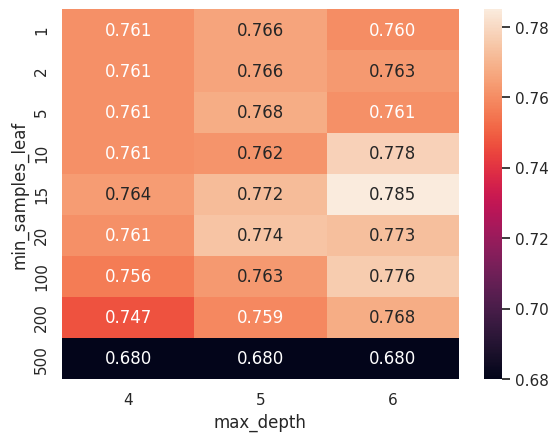

In [ ]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")
plt.show()

Train with newer parameters


In [ ]:
decision_tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
decision_tree.fit(X_train, y_train)
print(decision_tree)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)


## Ensembles

### Random Forest


In [ ]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=1)
random_forest.fit(X_train, y_train)
print(random_forest)

RandomForestClassifier(n_estimators=10, random_state=1)


Prediction with _Random Forest_


In [ ]:
y_validation_pred = random_forest.predict_proba(X_validation)[:, 1]
roc_auc_score(y_validation, y_validation_pred)

0.7744726453706618

Get scores for _Decision Tree_


In [ ]:
scores = []

for number in range(10, 201, 10):
    random_forest = RandomForestClassifier(n_estimators=number, random_state=1)
    random_forest.fit(X_train, y_train)

    y_validation_pred = random_forest.predict_proba(X_validation)[:, 1]
    auc = roc_auc_score(y_validation, y_validation_pred)

    scores.append((number, auc))

df_rt_scores = pd.DataFrame(
    scores,
    columns=["n_estimators", "roc_auc_score"],
)
df_rt_scores.head()

,n_estimators,roc_auc_score
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082


Plot parameters


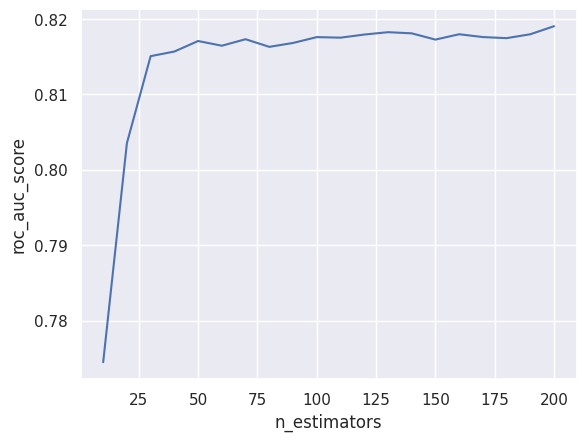

In [ ]:
plt.plot(df_rt_scores.n_estimators, df_rt_scores.roc_auc_score)
plt.xlabel("n_estimators")
plt.ylabel("roc_auc_score")
plt.show()

Add depth parameter


In [ ]:
scores = []

for depth in [5, 10, 15]:
    for number in range(10, 201, 10):
        random_forest = RandomForestClassifier(
            n_estimators=number,
            max_depth=depth,
            random_state=1,
        )
        random_forest.fit(X_train, y_train)

        y_validation_pred = random_forest.predict_proba(X_validation)[:, 1]
        auc = roc_auc_score(y_validation, y_validation_pred)

        scores.append((number, depth, auc))

df_rt_scores = pd.DataFrame(
    scores,
    columns=["max_depth", "n_estimators", "roc_auc_score"],
)
df_rt_scores.head()

,max_depth,n_estimators,roc_auc_score
0,10,5,0.787699
1,20,5,0.797731
2,30,5,0.800305
3,40,5,0.799708
4,50,5,0.799878
